<a href="https://colab.research.google.com/github/mykhailodolitsoi/EDU_pytorch/blob/main/02_pytorch_overall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
device = "cude" if torch.cuda.is_available() else "cpu"

In [ ]:
### FUNCTIONS SECTION
def t_info(name: str, tensor: torch.Tensor):
    t_type = type(tensor)
    t_shape = tensor.shape
    first_ex, last_ex = tensor[0], tensor[-1]
    print(f"Tensor name: {name} | tensors type: {t_type} | tensors shape {t_shape} | first value: {first_ex} | last_value: {last_ex}")
    print("--------------------")

def fn_acc(y_true, y_pred):
    return ((y_true == y_pred).float().mean() * 100).item()

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


Tensor name: X | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([1000, 2]) | first value: tensor([ 1.4973, -7.4881]) | last_value: tensor([ -0.4654, -11.2216])
--------------------
Tensor name: y | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([1000]) | first value: 3 | last_value: 3
--------------------
Tensor name: X_train | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([800, 2]) | first value: tensor([ 1.9779, -8.0867]) | last_value: tensor([-1.6599,  6.9569])
--------------------
Tensor name: X_test | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([200, 2]) | first value: tensor([ -0.4445, -10.0456]) | last_value: tensor([-10.6656,   7.3541])
--------------------
Tensor name: y_train | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([800]) | first value: 3 | last_value: 1
--------------------
Tensor name: y_test | tensors type: <class 'torch.Tensor'> | tensors shape torch.Size([200]) | first value

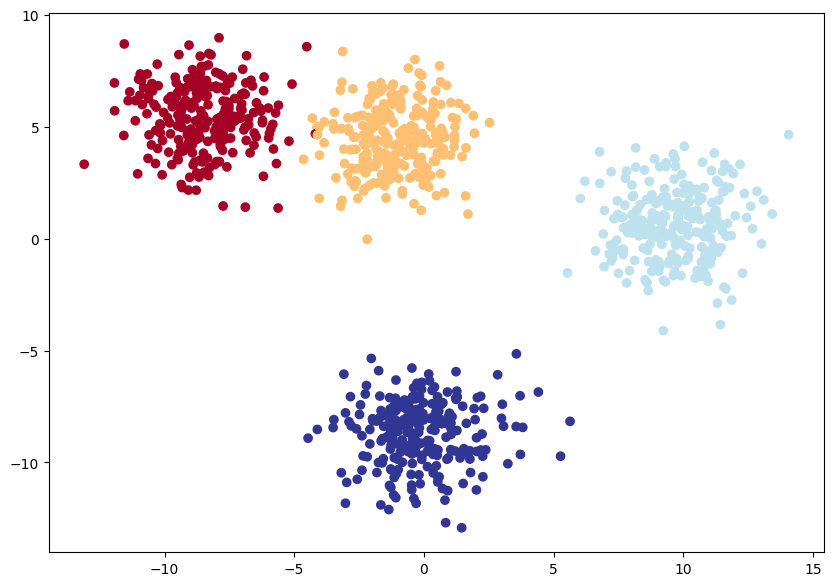

In [ ]:
### DATA SECTION
# set the hyperparameters
n_classes = 4
n_features = 2
rand_seed = 7

# create the data
X, y = make_blobs(n_samples=1000,
                  n_features=n_features,
                  centers=n_classes,
                  cluster_std=1.5,
                  random_state=rand_seed)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

t_info("X", X)
t_info("y", y)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

t_info("X_train", X_train)
t_info("X_test", X_test)
t_info("y_train", y_train)
t_info("y_test", y_test)

# visualize the data
plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [ ]:
### MODEL SECTION
class model(nn.Module):
    '''
    Initializes multi-class classification model

    Args:
        in_f (int): Number of input features of the model;
        hi_f1, hi_f2 (int): Number of features of hiden layer layer;
        ou_f (int): Number of output features(logits).


    '''
    def __init__(self,
                 in_f=2,
                 hi_f1=64,
                 hi_f2=16,
                 ou_f=4
                 ):
        super().__init__()

        # architecture
        # self.in_l = nn.Linear(in_features=in_f, out_features=hi_f1)
        # self.hi_l1 = nn.Linear(in_features=hi_f1,out_features=hi_f2)
        # self.ou_l = nn.Linear(in_features=hi_f2, out_features=ou_f)
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=in_f, out_features=hi_f1),
            nn.ReLU(),
            nn.Linear(in_features=hi_f1,out_features=hi_f2),
            nn.ReLU(),
            nn.Linear(in_features=hi_f2, out_features=ou_f)
        )

    def forward(self, x):
        # x = self.hi_l1(self.in_l(x))
        # x = self.ou_l(x)
        return self.layer_stack(x)

In [ ]:
torch.manual_seed(5)
torch.cuda.manual_seed(5)

model = model().to(device)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
epochs = 1000

for epoch in range(epochs):
    model.train()

    logits_train = model(X_train)
    loss_train = loss_fn(logits_train, y_train)

    optim.zero_grad()
    loss_train.backward()
    optim.step()

    y_pred_train = logits_train.argmax(dim=1)
    acc_train = fn_acc(y_train, y_pred_train)

    model.eval()
    with torch.inference_mode():
        logits_test = model(X_test)
        y_pred_test = logits_test.argmax(dim=1)

        loss_test = loss_fn(logits_train, y_train)
        acc_test = fn_acc(y_test, y_pred_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss_train/ Acc_train: {loss_train:.4f}, {acc_train:.2f}% | Loss_test/ Acc_test: {loss_test:.4f}, {acc_test:.2f}%")



Epoch: 0 | Loss_train/ Acc_train: 1.2652, 41.75% | Loss_test/ Acc_test: 1.2652, 74.00%
Epoch: 100 | Loss_train/ Acc_train: 0.0048, 99.88% | Loss_test/ Acc_test: 0.0048, 100.00%
Epoch: 200 | Loss_train/ Acc_train: 0.0036, 99.88% | Loss_test/ Acc_test: 0.0036, 100.00%
Epoch: 300 | Loss_train/ Acc_train: 0.0026, 99.88% | Loss_test/ Acc_test: 0.0026, 100.00%
Epoch: 400 | Loss_train/ Acc_train: 0.0017, 100.00% | Loss_test/ Acc_test: 0.0017, 100.00%
Epoch: 500 | Loss_train/ Acc_train: 0.0012, 100.00% | Loss_test/ Acc_test: 0.0012, 100.00%
Epoch: 600 | Loss_train/ Acc_train: 0.0011, 100.00% | Loss_test/ Acc_test: 0.0011, 100.00%
Epoch: 700 | Loss_train/ Acc_train: 0.0009, 100.00% | Loss_test/ Acc_test: 0.0009, 100.00%
Epoch: 800 | Loss_train/ Acc_train: 0.0008, 100.00% | Loss_test/ Acc_test: 0.0008, 100.00%
Epoch: 900 | Loss_train/ Acc_train: 0.0007, 100.00% | Loss_test/ Acc_test: 0.0007, 100.00%


In [ ]:
y_pred_test == y_test

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

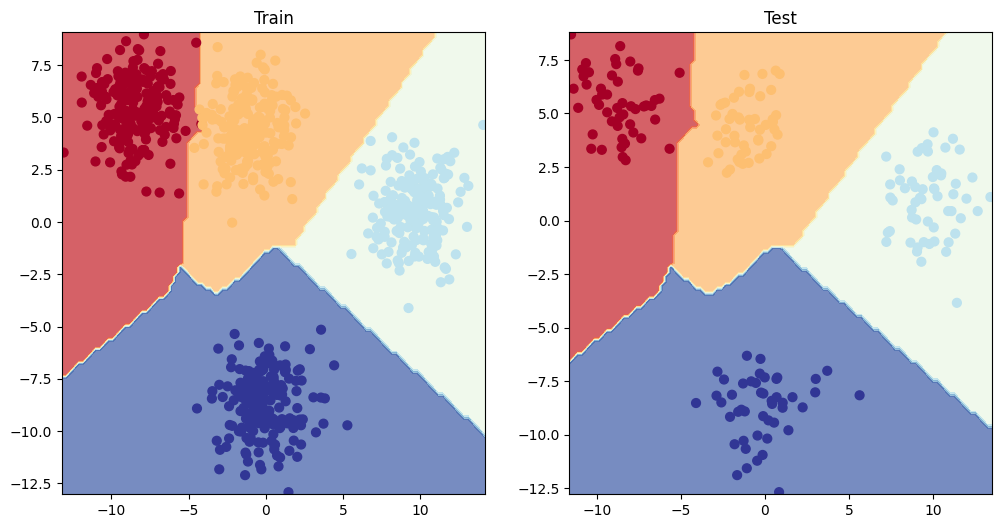

In [ ]:
# visualize the data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

## More classification metrics

* Accuracy - out of 100 samples, how many does our model classify correctly
* Precision - not to classify neg as pos
* Recoll - do not miss any pos
* F1
* Confusion matrix
* Classification report